In [1]:
import pickle
import sys
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

### Phone Baseline

In [89]:
importlib.reload(trajectory)
importlib.reload(energy)
importlib.reload(standardfeeds)
importlib.reload(vehicle)


# Load phone data
data_phone = standardfeeds.combine_phone_sensors("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/", chop_n=60)

short_name, veh_id = str.split(pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")

# Create trajectory then drive cycle
phone_traj = trajectory.Trajectory(
    point_attr={
        "lon": data_phone.longitude.to_numpy(),
        "lat": data_phone.latitude.to_numpy(),
        "measured_elev_m": data_phone.altitudeAboveMeanSeaLevel.to_numpy(),
        "measured_speed_m_s": data_phone.speed.to_numpy(),
        "measured_bear_d": data_phone.bearing.to_numpy(),
        "measured_accel_m_s2": data_phone.y.to_numpy(),
        "measured_theta_d": data_phone.pitch.to_numpy() - np.mean(data_phone.pitch.to_numpy()),
        "cumul_time_s": data_phone.cumul_time_s.to_numpy(),
    },
    traj_attr={
        "short_name": short_name,
        "veh_id": veh_id,
        "t_min_of_day": 300,
        "t_day_of_week": 0
    },
    coord_ref_center=[386910, 69022],
    epsg=32148,
    apply_filter=True
)

phone_cycle = phone_traj.to_momentary_drivecycle()
energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
phone_cycle_energy_df = energy_model.getEnergyDataFrame(phone_cycle)
energy_model.printSummary(phone_cycle)

4.813821558066627 kWh
1.2507329318332412 mi
3.848800519716744 Avg. kWh/mi


Text(0.5, 1.0, 'Total Distance (m)')

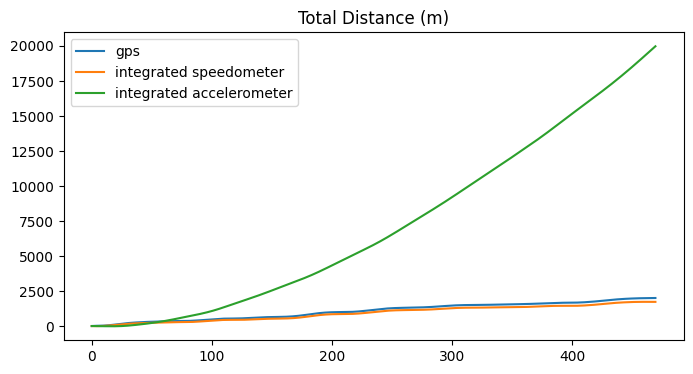

In [81]:
fig, axes = plt.subplots(1,1,figsize=(8,4))
phone_traj.gdf['calc_dist_m'].cumsum().plot(ax=axes)
phone_traj.gdf['measured_speed_m_s'].cumsum().plot(ax=axes)
phone_traj.gdf['measured_accel_m_s2'].cumsum().cumsum().plot(ax=axes)
axes.legend(['gps','integrated speedometer','integrated accelerometer'])
axes.set_title("Total Distance (m)")

Text(0.5, 1.0, 'Velocity (m/s)')

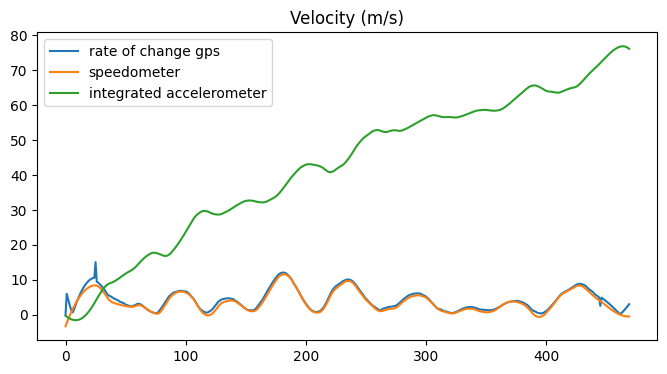

In [82]:
fig, axes = plt.subplots(1,1,figsize=(8,4))
phone_traj.gdf['calc_dist_m'].plot(ax=axes)
phone_traj.gdf['measured_speed_m_s'].plot(ax=axes)
phone_traj.gdf['measured_accel_m_s2'].cumsum().plot(ax=axes)
axes.legend(['rate of change gps','speedometer','integrated accelerometer'])
axes.set_title("Velocity (m/s)")

Text(0.5, 1.0, 'Acceleration (m/s^2)')

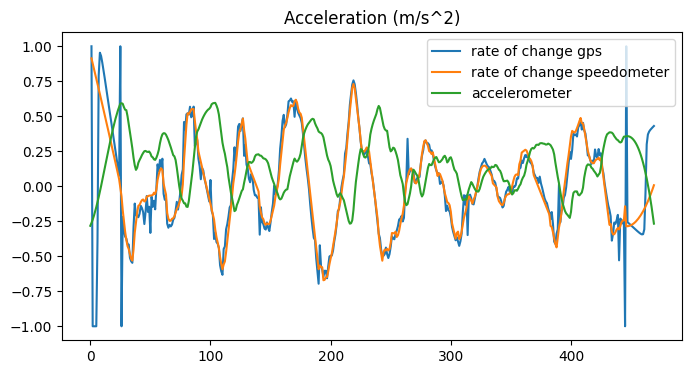

In [85]:
fig, axes = plt.subplots(1,1,figsize=(8,4))
phone_traj.gdf['calc_dist_m'].diff().clip(-1,1).plot(ax=axes)
phone_traj.gdf['measured_speed_m_s'].diff().plot(ax=axes)
phone_traj.gdf['measured_accel_m_s2'].plot(ax=axes)
axes.legend(['rate of change gps','rate of change speedometer','accelerometer'])
axes.set_title("Acceleration (m/s^2)")

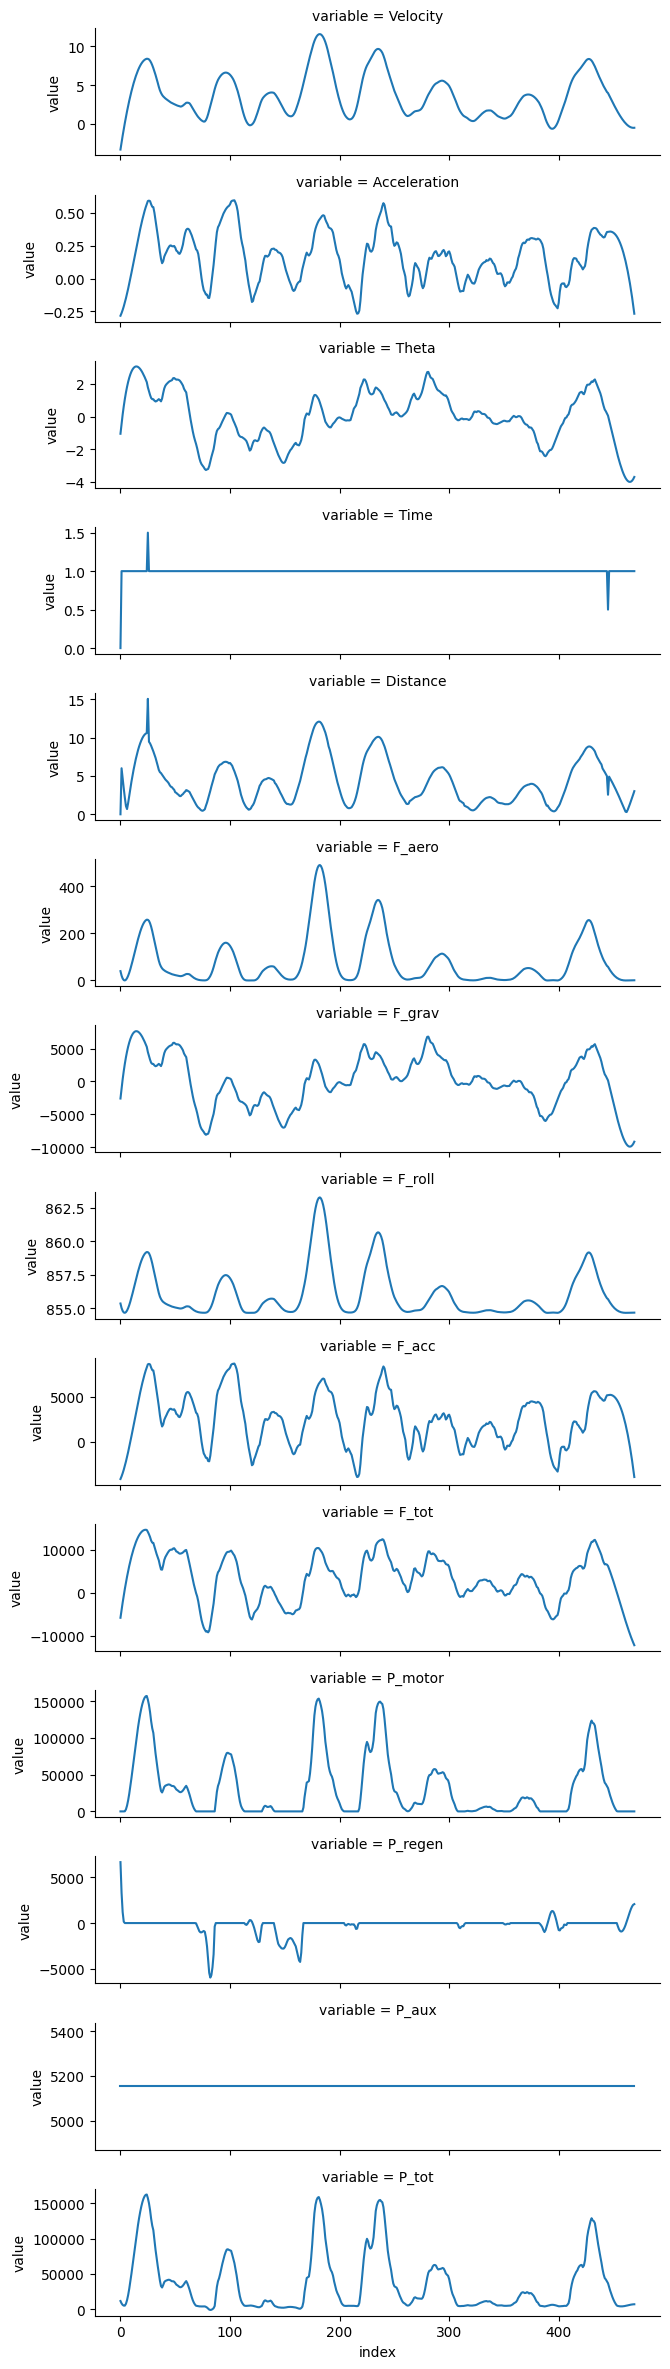

In [165]:
plotting.formatted_trajectory_lineplot(phone_cycle_energy_df)

In [ ]:
# Create resampled trajectory
phone_traj = trajectory.Trajectory(data_phone.longitude, data_phone.latitude, 322, 0, [386910,69022], 32148, resample_len=200)
model = model_utils.load_model('../logs/', 'kcm', 'GRU', 0)
phone_traj.update_predicted_time(model)

# Create trajectory then drive cycle
phone_cycle = phone_traj.to_drivecycle("../data/kcm_spatial/usgs10m_dem_32148.tif")
cycle_df = phone_cycle.to_df()
cycle_df['F_aero'], cycle_df['F_grav'], cycle_df['F_roll'], cycle_df['F_acc'], cycle_df['F_tot'] = energy_model.calcTotalLoad(phone_cycle, combine=False)
cycle_df['P_motor'], cycle_df['P_regen'], cycle_df['P_aux'], cycle_df['P_tot'] = energy_model.calcTotalPower(phone_cycle, combine=False)
energy_model.printSummary(phone_cycle)
cycle_df.head()

In [ ]:
plotting.formatted_trajectory_lineplot(cycle_df)

In [75]:
# Create resampled trajectory
phone_traj = trajectory.Trajectory(data_phone.longitude, data_phone.latitude, 322, 0, [386910,69022], 32148, resample_len=200)
model = pickle.load(open(f"../logs/kcm/AVG-0.pkl", 'rb'))
phone_traj.update_predicted_time(model)

# Create trajectory then drive cycle
phone_cycle = phone_traj.to_drivecycle("../data/kcm_spatial/usgs10m_dem_32148.tif")
cycle_df = phone_cycle.to_df()
cycle_df['F_aero'], cycle_df['F_grav'], cycle_df['F_roll'], cycle_df['F_acc'], cycle_df['F_tot'] = energy_model.calcTotalLoad(phone_cycle, combine=False)
cycle_df['P_motor'], cycle_df['P_regen'], cycle_df['P_aux'], cycle_df['P_tot'] = energy_model.calcTotalPower(phone_cycle, combine=False)
energy_model.printSummary(phone_cycle)
cycle_df.head()

TypeError: __init__() got multiple values for argument 'resample_len'

In [ ]:
plotting.formatted_trajectory_lineplot(cycle_df)

In [ ]:
# GTFS shapes
shape_lookup = standardfeeds.get_gtfs_shapes_lookup(f"../data/kcm_gtfs/{static_date}/")
shapes = standardfeeds.get_gtfs_shapes(f"../data/kcm_gtfs/{static_date}/").to_crs("EPSG:32148")
shapes.plot()

In [ ]:
route_ids = pd.unique(data_gtfs[(data_gtfs['route_short_name']==short_name) & (data_gtfs['direction_id']==0)].route_id)
phone_shape = shapes[(shapes['route_id'].isin(route_ids)) & (shapes['direction_id']==0) & (shapes['service_id']==21133)]

In [ ]:
# Get one shape to work with
sample_service_id, sample_route_id, sample_direction_id = data_gtfsrt.groupby(['service_id','route_id','direction_id']).count().index[0]
print(sample_service_id, sample_route_id, sample_direction_id)

# GTFS-RT
sample_realtime = data_gtfsrt[(data_gtfsrt['service_id']==sample_service_id) & (data_gtfsrt['route_id']==sample_route_id) & (data_gtfsrt['direction_id']==sample_direction_id)].copy()

# Shape
sample_shape = shapes[(shapes['service_id']==sample_service_id) & (shapes['route_id']==sample_route_id) & (shapes['direction_id']==sample_direction_id)].copy()
sample_shape.plot()

In [ ]:
# Get distance along shape
sample_realtime['dist_along_line'] = sample_realtime['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))
# sample_static['dist_along_line'] = sample_static['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))

# Also get a timestamp column on the samples
sample_realtime['t'] = pd.to_datetime(sample_realtime['locationtime'], unit='s')
sample_realtime = sample_realtime.set_index('t')

In [ ]:
# ax = sns.lineplot(sample_static, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False).set_ylim(0,25)

In [ ]:
sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False).set_ylim(0,25)

In [ ]:
plotting.formatted_basemap_scatterplot(sample_realtime)

In [ ]:
plotting.formatted_basemap_scatterplot(sample_shape)

In [ ]:
filtered = sm.nonparametric.lowess(endog=sample_realtime['calc_speed_m_s'], exog=sample_realtime['dist_along_line'], frac=0.01, it=1)
axes = sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)
sns.lineplot(x=filtered[:,0], y=filtered[:,1], ax=axes, color='black')

In [ ]:
# Compute the 95% confidence interval
eval_x = np.linspace(0, max(sample_realtime['dist_along_line'].values))
smoothed, bottom, top = plotting.lowess_with_confidence_bounds(sample_realtime['dist_along_line'].values, sample_realtime['calc_speed_m_s'].values, eval_x, lowess_kw={"frac": 0.01})
axes = sns.lineplot(sample_realtime, x='dist_along_line', y='calc_speed_m_s', hue='trip_id', legend=False)
# axes.set_xlim(0,5000)
# axes.set_ylim(0,20)
sns.lineplot(x=eval_x, y=smoothed, color='black', ax=axes)
sns.lineplot(x=eval_x, y=top, color='blue', ax=axes)
sns.lineplot(x=eval_x, y=bottom, color='blue', ax=axes)

In [ ]:
data_phone['dist_along_line'] = data_phone['geometry'].apply(lambda pt: shapely.line_locate_point(phone_shape.geometry, pt))


In [ ]:
fig, axes = plotting.formatted_basemap_scatterplot(data_phone)
phone_shape.plot(ax=axes, color='black')

In [ ]:
sns.lineplot(data_phone, x='dist_along_line', y='calc_speed_m_s')

### Trip GPS Points

In [ ]:
data_phone = pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Location.csv")
short_name, veh_id = str.split(pd.read_csv("../data/kcm_sensor/8124-33-2022-10-17_20-52-26/Annotation.csv").iloc[0].text,"-")
data_phone = gpd.GeoDataFrame(data_phone, geometry=gpd.points_from_xy(data_phone.longitude, data_phone.latitude), crs="EPSG:4326").to_crs("EPSG:32148")
_, _, data_phone['calc_speed_m_s'] = spatial.calculate_speed(data_phone, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(data_phone, "Phone Basemap")

In [ ]:
data_gtfs = data_utils.merge_gtfs_files("../data/kcm_gtfs/2023_05_14/", epsg="32148", coord_ref_center=[386910,69022])
gtfs_calendar = pd.read_csv("../data/kcm_gtfs/2023_05_14/calendar.txt")
filtered_gtfs, remaining_trip_ids = data_utils.filter_gtfs_w_phone(data_phone, data_gtfs, short_name, gtfs_calendar)
filtered_gtfs = gpd.GeoDataFrame(filtered_gtfs, geometry=gpd.points_from_xy(filtered_gtfs.stop_lon, filtered_gtfs.stop_lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfs['seconds_elapsed'] = filtered_gtfs['arrival_s'] - filtered_gtfs['arrival_s'].iloc[0]
_, _, filtered_gtfs['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfs, 'seconds_elapsed')
plotting.formatted_basemap_scatterplot(filtered_gtfs, "GTFS Basemap")

In [ ]:
data_gtfsrt = pd.read_pickle("../data/kcm_realtime/2023_05_20.pkl")
data_gtfsrt['locationtime'] = pd.to_numeric(data_gtfsrt['locationtime'])
filtered_gtfsrt_daily = data_gtfsrt[data_gtfsrt['trip_id'].isin(remaining_trip_ids)]
filtered_gtfsrt_one = filtered_gtfsrt_daily[filtered_gtfsrt_daily['trip_id']==remaining_trip_ids[0]]
filtered_gtfsrt_one = gpd.GeoDataFrame(filtered_gtfsrt_one, geometry=gpd.points_from_xy(filtered_gtfsrt_one.lon, filtered_gtfsrt_one.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_one['seconds_elapsed'] = filtered_gtfsrt_one['locationtime'] - filtered_gtfsrt_one['locationtime'].iloc[0]
_, _, filtered_gtfsrt_one['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_one, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_one, "GTFS-RT Basemap One Trip")

In [ ]:
filtered_gtfsrt_daily = gpd.GeoDataFrame(filtered_gtfsrt_daily, geometry=gpd.points_from_xy(filtered_gtfsrt_daily.lon, filtered_gtfsrt_daily.lat), crs="EPSG:4326").to_crs("EPSG:32148")
filtered_gtfsrt_daily['seconds_elapsed'] = filtered_gtfsrt_daily['locationtime'] - filtered_gtfsrt_daily['locationtime'].iloc[0]
_, _, filtered_gtfsrt_daily['calc_speed_m_s'] = spatial.calculate_speed(filtered_gtfsrt_daily, 'locationtime')
plotting.formatted_basemap_scatterplot(filtered_gtfsrt_daily, "GTFS-RT Basemap Daily Trips")

### Drive Cycles

In [ ]:
data_melt_phone = pd.melt(data_phone, id_vars=['seconds_elapsed'], value_vars=['speed','calc_speed_m_s','altitudeAboveMeanSeaLevel'])
plotting.formatted_rel_lineplot(data_melt_phone, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='Phone Speed')

In [ ]:
filtered_melt_gtfs = pd.melt(filtered_gtfs, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfs, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS Speed', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_one = pd.melt(filtered_gtfsrt_one, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_one, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle One Trip', xlim=(0,2000), ylim=(0,35))

In [ ]:
filtered_melt_gtfsrt_daily = pd.melt(filtered_gtfsrt_daily, id_vars=['seconds_elapsed'], value_vars=['calc_speed_m_s'])
plotting.formatted_rel_lineplot(filtered_melt_gtfsrt_daily, x_var='seconds_elapsed', y_var='value', rel_var='variable', title_text='GTFS-RT Drive Cycle Daily Trips')